In [1]:
import os, sys
os.environ['ON_PY']="1"
os.chdir("/home/wlc/FJSP-DRL-MAML")
from params import parser
from common_utils import setup_seed
from data_utils import pack_data_from_config
import numpy as np
from test_script.base import Test
import matplotlib.pyplot as plt
import numpy as np

notebook_dir = os.getcwd()
print(notebook_dir)
# 将工作目录更改为上一级目录



(CVXPY) Apr 25 10:15:07 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 25 10:15:07 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/home/wlc/FJSP-DRL-MAML


In [2]:
instances = ["10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",]

plot_dict = {}
for key in instances:
    plot_dict[key] = [np.array(11) for _ in range(4)]

plot_dict

{'10x5+mix': [array(11), array(11), array(11), array(11)],
 '20x5+mix': [array(11), array(11), array(11), array(11)],
 '15x10+mix': [array(11), array(11), array(11), array(11)],
 '20x10+mix': [array(11), array(11), array(11), array(11)]}

In [3]:
# 数学解
extra_args = ["--lr", "1e-3",]
test_data = ["10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",]


In [4]:
# DAN 解

args = [*extra_args, "--test_data", *test_data, 
        "--test_model", "10x5x0+mix","20x5x0+mix", "15x10x0+mix", "20x10x0+mix"]
configs = parser.parse_args(args=args)

setup_seed(configs.seed_test)


test_model = []

for model_name in configs.test_model:
    test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
print(test_model)
test_data_pack = pack_data_from_config(configs.data_source, configs.test_data)

print(os.getcwd())
baseline_makespans = []
for i in range(len(test_model)):
    model = test_model[i]
    data = test_data_pack[i]
    print("datta[1]: ",data[1])
    print("-" * 25 + "Test Learned Model" + "-" * 25)
    print(f"test data name: {data[1]}")
    finetuning = True if model[1].startswith("maml") else False
    print(f"Model name : {model[1]}")
    result_5_times = []
    for j in range(2):
        test = Test(configs, data[0], model[0])
        result = test.greedy_strategy(finetuning=finetuning)
        # result = test_greedy_strategy(data[0], model[0], config.seed_test)
        
        result_5_times.append(result)
    result_5_times = np.array(result_5_times)

    save_result = np.mean(result_5_times, axis=0)
    print("testing results:")
    print(f"makespan(greedy): ", save_result[:, 0].mean())
    baseline_makespans.append(save_result[:, 0].mean())
    print(f"time: ", save_result[:, 1].mean())
    # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
    # print(f"Average fast_adapt time:", save_result[:, 3].mean())
    print("="*100)

print(baseline_makespans)




[('./trained_network/SD2/10x5x0+mix.pth', '10x5x0+mix'), ('./trained_network/SD2/20x5x0+mix.pth', '20x5x0+mix'), ('./trained_network/SD2/15x10x0+mix.pth', '15x10x0+mix'), ('./trained_network/SD2/20x10x0+mix.pth', '20x10x0+mix')]
/home/wlc/FJSP-DRL-MAML
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : 10x5x0+mix
testing results:
makespan(greedy):  444.4
time:  0.31659936904907227
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : 20x5x0+mix
testing results:
makespan(greedy):  730.7
time:  0.5990506768226623
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : 15x10x0+mix
testing results:
makespan(greedy):  598.4
time:  0.91163729429245
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name 

In [5]:
# MAML finetuning
# 获取finetuning的每个过程
class MAMLfinetuningClass:
    
    param_list_finetuning = []
    
    @staticmethod
    def MAML_finetuning_test(args):
        configs = parser.parse_args(args=args)
        print(configs.hidden_dim_actor, configs.hidden_dim_critic)
        test_model = []

        for model_name in configs.test_model:
            test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
        print(test_model)

        model = test_model[0]

        test_data = pack_data_from_config(configs.data_source, configs.test_data)
        finetuning_makespans = []
        finetuning_test_results_makespans = []
        MAMLfinetuningClass.param_list_finetuning = []
        for data in test_data:
            print("datta[1]: ",data[1])
            print("-" * 25 + "Test Learned Model" + "-" * 25)
            print(f"test data name: {data[1]}")
            if model[1].startswith("maml"): finetuning = True
            print(f"Model name : {model[1]}")
            result_5_times = []
            test = Test(configs, data[0], model[0])
            for i in range(5):
                test.finetuning(times=1)
                test.greedy_strategy()

            MAMLfinetuningClass.param_list_finetuning.append(test.adapt_param_list)
            finetuning_makespans.append(test.finetuning_makespan)
            save_result = np.array(test.test_result_list)
            finetuning_test_results_makespans.append(save_result[:, 0])

            print("testing results:")
            print(f"makespan(greedy): ", save_result[:, 0].mean())
            print(f"time: ", save_result[:, 1].mean())
            print("="*100)

        return finetuning_test_results_makespans, finetuning_makespans

def MAML_finetuning_test(args):
    return MAMLfinetuningClass.MAML_finetuning_test(args)


In [6]:
from sklearn.decomposition import PCA
from model.PPO import PPO_initialize
import torch
# 初始化 PPO 和参数列表
models = [f"{n_j}x{n_m}x0+mix" for n_j in range(5, 26, 5) for n_m in range(5, 26, 5) if n_j > n_m]
models.append("10x5+mix+SD2")
args = [*extra_args, "--test_data", *test_data, "--test_model", *models]
print(args)
configs = parser.parse_args(args=args)
test_model = [(f'./trained_network/{configs.model_source}/{model_name}.pth', model_name) for model_name in configs.test_model]

param_list = []

# 加载模型参数
for model_path, model_name in test_model:
    ppo = PPO_initialize(configs)
    # print(model_path)
    ppo.policy.load_state_dict(torch.load(model_path, map_location='cuda'))
    parameters = list(ppo.policy.actor.parameters())
    
    param_list.append(parameters)


['--lr', '1e-3', '--test_data', '10x5+mix', '20x5+mix', '15x10+mix', '20x10+mix', '--test_model', '10x5x0+mix', '15x5x0+mix', '15x10x0+mix', '20x5x0+mix', '20x10x0+mix', '20x15x0+mix', '25x5x0+mix', '25x10x0+mix', '25x15x0+mix', '25x20x0+mix', '10x5+mix+SD2']


64 64
[('./trained_network/SD2/maml+MAMLMK1713360447.pth', 'maml+MAMLMK1713360447')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+MAMLMK1713360447
testing results:
makespan(greedy):  463.46000000000004
time:  0.3026781845092773
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+MAMLMK1713360447
testing results:
makespan(greedy):  731.9200000000001
time:  0.6564596080780029
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+MAMLMK1713360447
testing results:
makespan(greedy):  635.0
time:  0.9413515090942383
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+MAMLMK1713360447
testing results:
makespan(greedy):  709.86
time:  1.2903614807128907


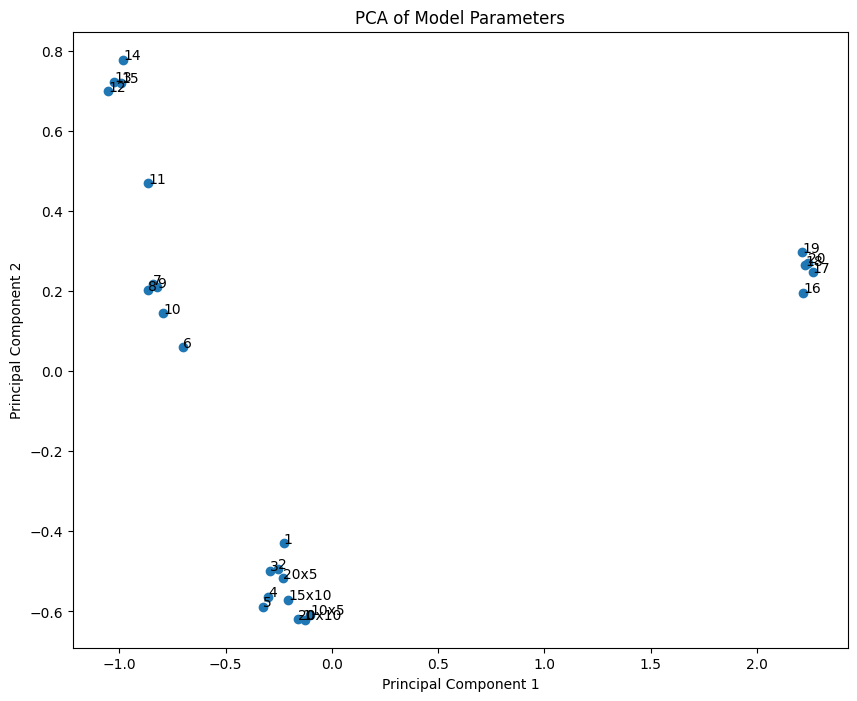

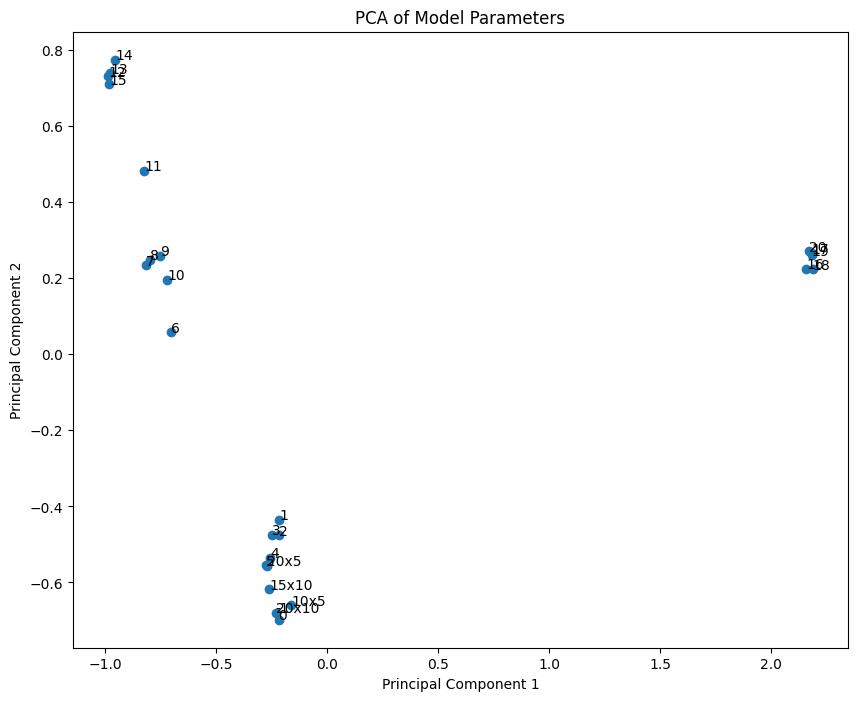

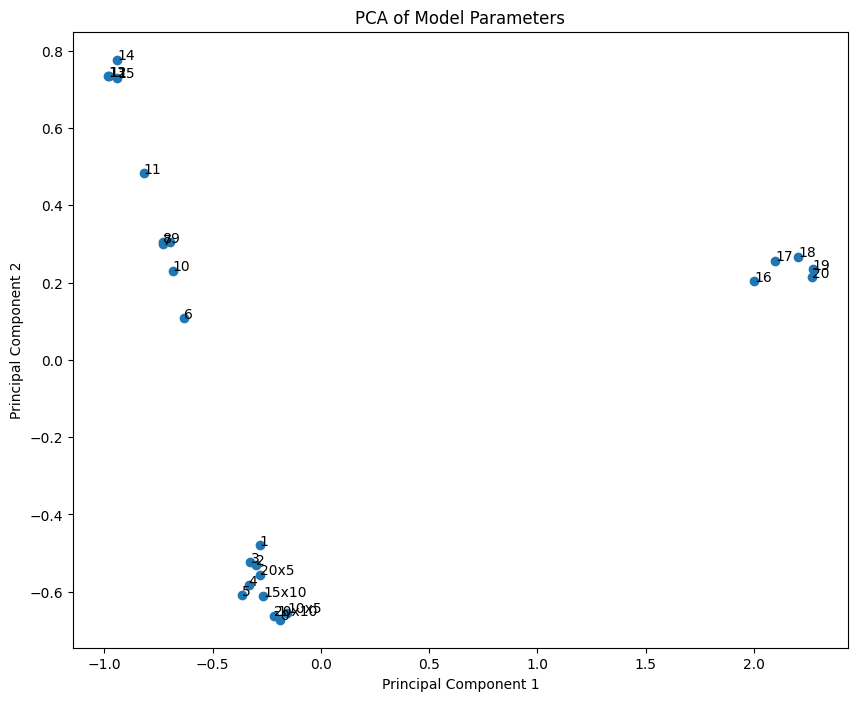

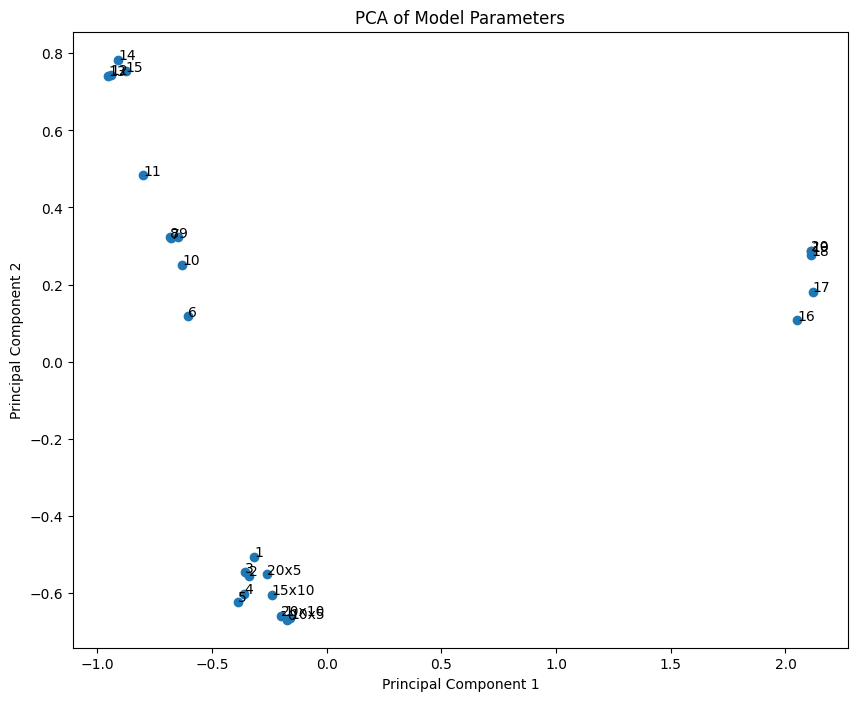

[array([458.9, 468. , 472.9, 452.5, 465. ]), array([728.1, 725.9, 731.8, 734.1, 739.7]), array([637.2, 617.8, 635.4, 647. , 637.6]), array([713.9, 694.7, 713. , 713.9, 713.8])]
[[601.0, 430.0, 468.0, 438.0, 416.0], [1151.0, 727.0, 724.0, 743.0, 767.0], [969.0, 703.0, 643.0, 654.0, 613.0], [1260.0, 784.0, 771.0, 777.0, 752.0]]


In [16]:
model = "maml+exp18-9"
# model = "maml+exp18-10"
# model = "maml+EXP19maml1707148858" #调整为竞争的工件和机器
# model = "maml+EXP19maml1707189752" #调整训练次数1->4
# model = "maml+EXP19maml1707277364" #只用MAML训练actor
# model = "maml+EXP19maml1708610726" # 内部更新feature_exact
# model = "maml+EXP19maml1709199921" # 缓更新
# model = "maml+EXP19maml1709210851" # adapt_lr=0.01
# model = "maml+EXP19maml1709211969" # adapt_lr=0.001
# model = "maml+EXP19maml1709212192" ## adapt_lr=0.0001
model = "maml+EXP19maml1709367712" # 无缓更新技术
model = "maml+EXP19maml1709693698"  ## feature_exact
model = "maml+EXP19maml1709779578"  # iter 500 + op_per_job=10
model = "maml+EXP19maml1709779197"  # iter = 500 op_per_job=M
model = "maml+EXP19maml1709816607"  ### 缓更新  iter=400
model = "maml+MAMLMK1713260928"
model = "maml+MAMLMK1713360447" 
# model = "maml+MAMLMK1713967313"   #三任务
args = [*extra_args, "--test_data", *test_data, 
        "--test_model", model]

maml_makespans, maml_finetuning_makespans = MAML_finetuning_test(args)
# 创建参数矩阵
for finetuning_param in MAMLfinetuningClass.param_list_finetuning:
    collation_param = [*param_list, *finetuning_param]
    param_matrix = np.array([np.concatenate([p.data.cpu().numpy().flatten() for p in params]).flatten() for params in collation_param])

    # 使用 PCA 进行降维
    pca = PCA(n_components=2)
    params_reduced = pca.fit_transform(param_matrix)

    # 绘制结果，为每个点添加模型名称标签
    plt.figure(figsize=(10, 8))  # 可以调整大小以更好地适应所有标签
    plt.scatter(params_reduced[:, 0], params_reduced[:, 1], marker='o')

    # print(params_reduced)
    # 为每个点添加文本标签
    end_i = 0
    for i, label in enumerate([name for _, name in test_model]):
        plt.annotate(label[:-6], (params_reduced[i, 0], params_reduced[i, 1]))
        end_i = i
    
    while end_i < len(params_reduced):
        plt.annotate(f"{end_i - len(test_model)}", (params_reduced[end_i, 0], params_reduced[end_i, 1]))
        end_i += 1

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Model Parameters')
    plt.show()
print(maml_makespans)
print(maml_finetuning_makespans)


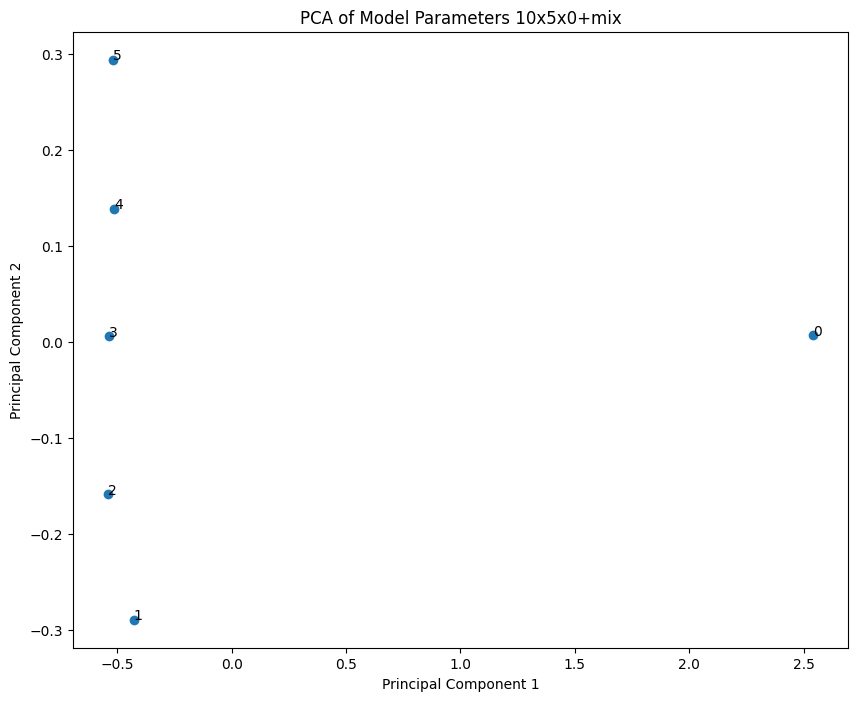

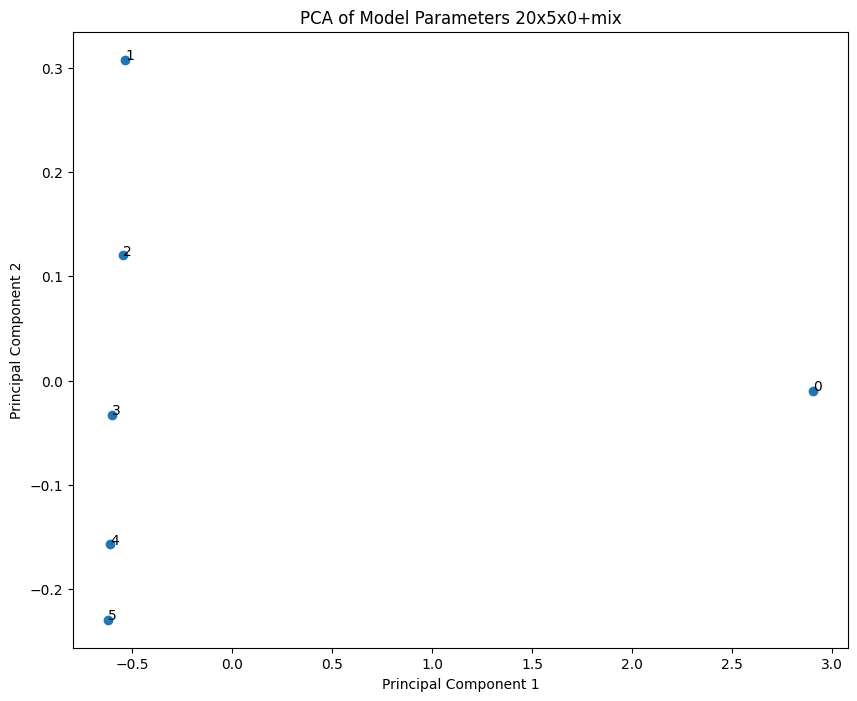

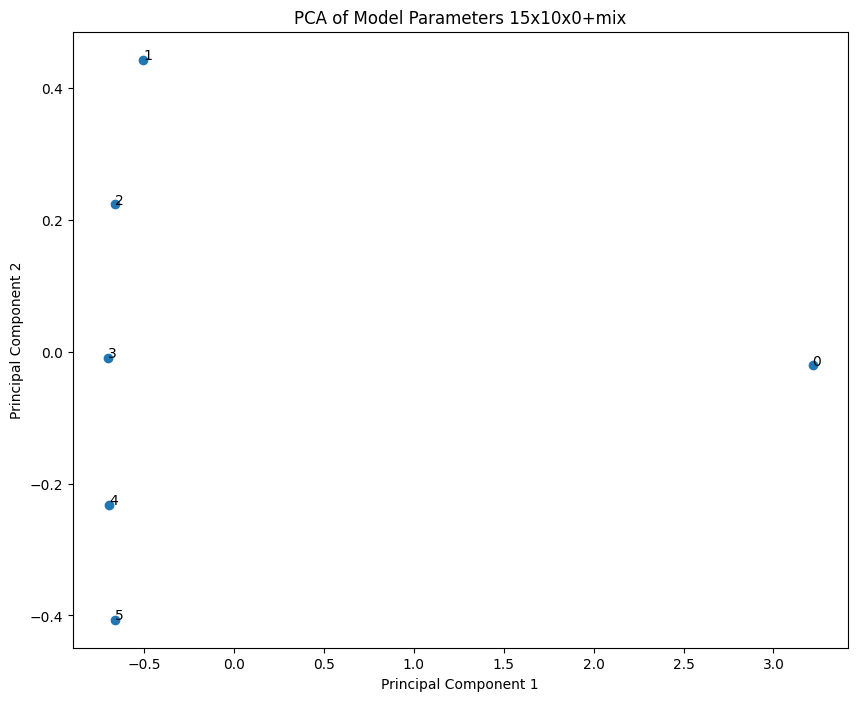

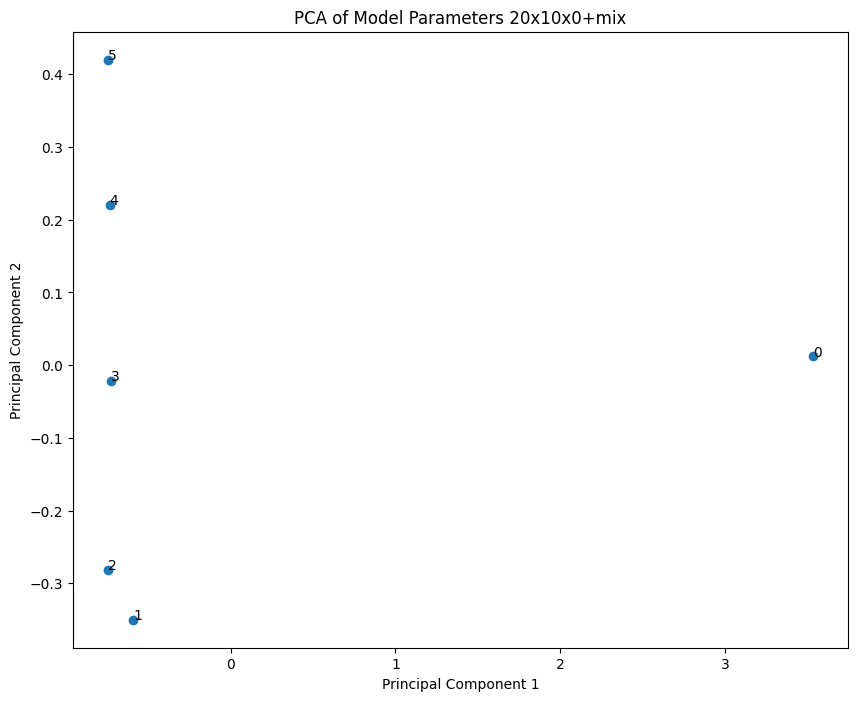

In [8]:
target_tasks = ["10x5x0+mix","20x5x0+mix", "15x10x0+mix", "20x10x0+mix"]
test_model = [(f'./trained_network/SD2/{model_name}.pth', model_name) for model_name in 
              target_tasks]

for i in range(4):
    model_path, model_name = test_model[i]
    finetuning_param = MAMLfinetuningClass.param_list_finetuning[i]
    ppo = PPO_initialize(configs)
    # print(model_path)
    ppo.policy.load_state_dict(torch.load(model_path, map_location='cuda'))
    parameters = list(ppo.policy.actor.parameters())
    collation_param = [parameters, *finetuning_param]
    param_matrix = np.array([np.concatenate([p.data.cpu().numpy().flatten() for p in params]).flatten() for params in collation_param])

    # 使用 PCA 进行降维
    pca = PCA(n_components=2)
    params_reduced = pca.fit_transform(param_matrix)

    # 绘制结果，为每个点添加模型名称标签
    plt.figure(figsize=(10, 8))  # 可以调整大小以更好地适应所有标签
    plt.scatter(params_reduced[:, 0], params_reduced[:, 1], marker='o')
    
    idx = 0
    while idx < len(params_reduced):
        plt.annotate(f"{idx}", (params_reduced[idx, 0], params_reduced[idx, 1]))
        idx += 1

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA of Model Parameters {model_name}')
    plt.show()
    


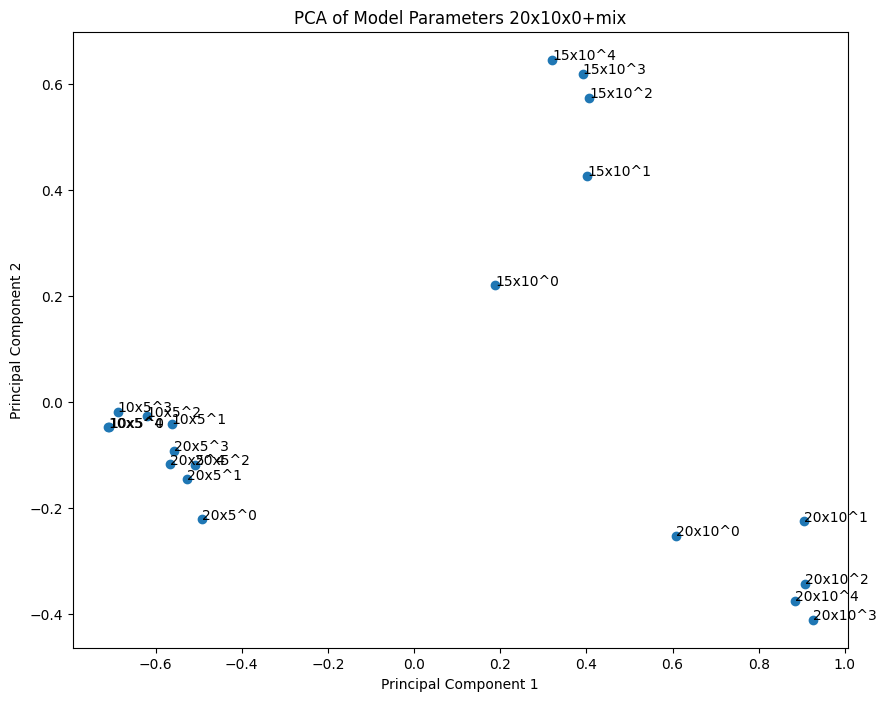

In [9]:
param_list = []
model_name_list = []
for i, model_name in enumerate(target_tasks):
    finetuning_param = MAMLfinetuningClass.param_list_finetuning[i]
    model_name_list += [model_name for _ in finetuning_param]
    param_list += finetuning_param

param_matrix = np.array([np.concatenate([p.data.cpu().numpy().flatten() for p in params]).flatten() for params in param_list])

# 使用 PCA 进行降维
pca = PCA(n_components=2)
params_reduced = pca.fit_transform(param_matrix)

# 绘制结果，为每个点添加模型名称标签
plt.figure(figsize=(10, 8))  # 可以调整大小以更好地适应所有标签
plt.scatter(params_reduced[:, 0], params_reduced[:, 1], marker='o')

idx = 0
while idx < len(params_reduced):
    plt.annotate(f"{model_name_list[idx][:-6]}^{idx%len(MAMLfinetuningClass.param_list_finetuning[0])}", (params_reduced[idx, 0], params_reduced[idx, 1]))
    idx += 1

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA of Model Parameters {model_name}')
plt.show()



In [10]:
# pretrain finetuning

args = [*extra_args, "--test_data", *test_data,  
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "maml+EXP19maml1709218650"]

pre_train_makespans, pre_train_finetuning_makespans = MAML_finetuning_test(args)


print(plot_dict)

512 512
[('./trained_network/SD2/maml+EXP19maml1709218650.pth', 'maml+EXP19maml1709218650')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+EXP19maml1709218650
testing results:
makespan(greedy):  501.88
time:  0.3091510152816772
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+EXP19maml1709218650
testing results:
makespan(greedy):  876.3
time:  0.6227081012725829
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+EXP19maml1709218650
testing results:
makespan(greedy):  646.72
time:  0.9534562921524048
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+EXP19maml1709218650
testing results:
makespan(greedy):  978.0799999999999
time:  1.2703892946243287
{'10x5+mi

In [11]:
# random
import torch
from model.PPO import PPO_initialize

ppo = PPO_initialize(configs)

torch.save(ppo.policy.state_dict(), f'./trained_network/SD2/test_random.pth')

args = [*extra_args, "--test_data", *test_data, 
        "--test_model", "test_random"]

random_makespans, random_finetuning_makespans = MAML_finetuning_test(args)



64 64
[('./trained_network/SD2/test_random.pth', 'test_random')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : test_random
testing results:
makespan(greedy):  515.3599999999999
time:  0.3041688060760498
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : test_random
testing results:
makespan(greedy):  911.96
time:  0.6235260915756227
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : test_random
testing results:
makespan(greedy):  638.96
time:  0.9377690362930299
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : test_random
testing results:
makespan(greedy):  813.0200000000001
time:  1.2514029932022095


In [12]:
from plot_imgs.plt_utils import plot_funetuning


In [13]:
# maml_finetuning_makespans
# pre_train_finetuning_makespans
# random_finetuning_makespans
maml_makespans

[array([474.1, 481.3, 459.1, 450.8, 461.7]),
 array([733.3, 723.4, 727.8, 748.4, 735.5]),
 array([608.2, 645.5, 647.5, 649.1, 641.2]),
 array([716.9, 752. , 742.2, 729.6, 759.2])]

In [14]:
# maml_finetuning_makespans = np.array(maml_finetuning_makespans[:,0])
# pre_train_finetuning_makespans = np.array(pre_train_finetuning_makespans[:, 0])
# random_finetuning_makespans = np.array(random_finetuning_makespans[:,0])
# maml_finetuning_makespans.shape

{'10x5+mix': [array([444.4, 444.4, 444.4, 444.4, 444.4]), [601.0, 430.0, 468.0, 438.0, 416.0], [778.0, 471.0, 492.0, 527.0, 456.0], [601.0, 622.0, 616.0, 609.0, 661.0]], '20x5+mix': [array([730.7, 730.7, 730.7, 730.7, 730.7]), [1151.0, 727.0, 724.0, 743.0, 767.0], [1225.0, 910.0, 960.0, 923.0, 946.0], [1151.0, 1115.0, 1231.0, 1089.0, 1170.0]], '15x10+mix': [array([598.4, 598.4, 598.4, 598.4, 598.4]), [969.0, 703.0, 643.0, 654.0, 613.0], [1290.0, 715.0, 719.0, 765.0, 652.0], [969.0, 991.0, 810.0, 809.0, 780.0]], '20x10+mix': [array([659., 659., 659., 659., 659.]), [1260.0, 784.0, 771.0, 777.0, 752.0], [1556.0, 933.0, 1039.0, 1091.0, 990.0], [1260.0, 1107.0, 1108.0, 1106.0, 1078.0]]}


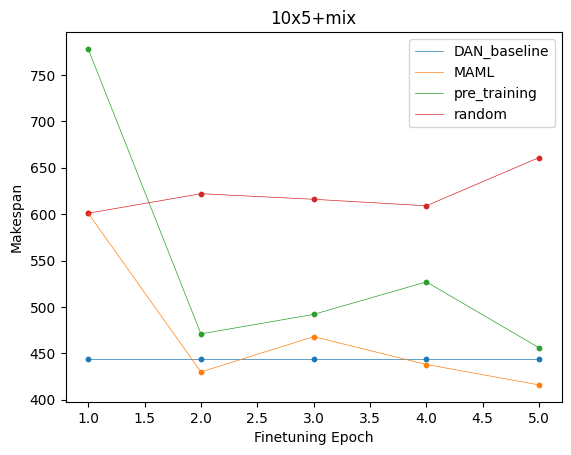

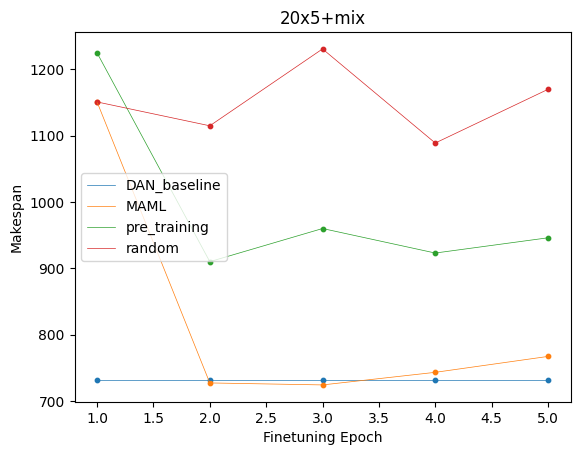

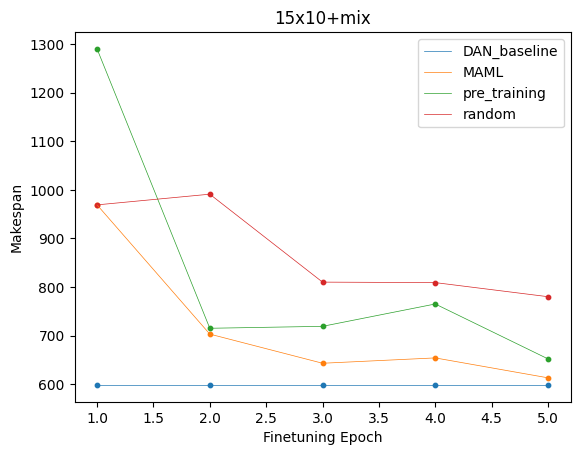

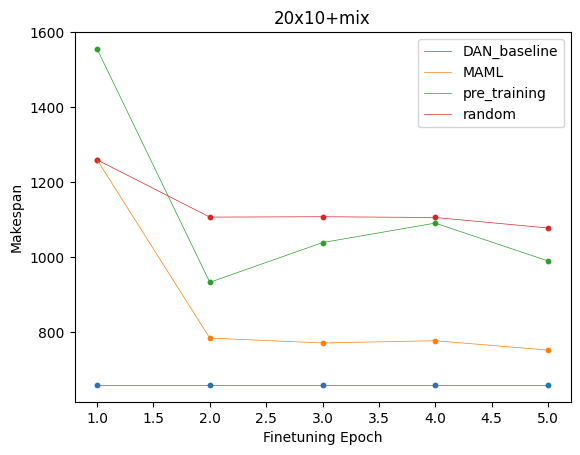

In [17]:

for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    plot_dict[key][0] = np.full(5, baseline_makespans[idx])
    plot_dict[key][1] = maml_finetuning_makespans[idx][:5]
    plot_dict[key][2] = pre_train_finetuning_makespans[idx][:5]
    plot_dict[key][3] = random_finetuning_makespans[idx][:5]

print(plot_dict)

for key in instances:
    data = plot_dict[key]
    plot_funetuning(data, key, label=1)